<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>SPRINT 14 MACHINE LEARNING FOR TEXTS PROJECT</h2> 
   
The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgray; color: black;">
    <h2>Project Summary: IMDB Sentiment Analysis</h2>

**Goal**: Develop a model to classify IMDB movie reviews as positive or negative using sentiment analysis
    
**Metric**: F1 Score of at least 0.85 on the test set
    
**Best Model:** NLTK + TF-IDF + Logistic Regression (F1 = 0.89)  
    
**Other Strong Models:** spaCy + TF-IDF + Logistic Regression (F1 = 0.88), spaCy + TF-IDF + LGBM (F1 = 0.83)  
    
**Data Period**: Mixed release years from early 1900s to 2010  
    
**Techniques Used**:
- Data preprocessing using NLTK and spaCy for text lemmatization and stopword removal
- TF-IDF vectorization to convert text data into numerical format
- Logistic Regression and LGBMClassifier for classification
- Model evaluation using accuracy, F1 Score, ROC AUC, and APS metrics
- **Exclusion: BERT was considered but excluded due to excessive processing time and poor predictive performance on a reduced dataset**



**Conclusion**: The NLTK + TF-IDF + Logistic Regression model is the most reliable and accurate for classifying IMDB movie reviews as positive or negative. It meets the F1 score ≥ 0.85 requirement, maintains strong generalization, and consistently outperforms spaCy + Logistic Regression and LGBM models. While spaCy offers comparable performance, LGBM shows signs of overfitting and skewed positive predictions
                                                          
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 1: INITIALIZING</h2>

</div>

In [1]:
!pip install psutil

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import sklearn.metrics as metrics
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import re
from sklearn.dummy import DummyClassifier
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import os
import spacy
from lightgbm import LGBMClassifier
import torch
import transformers
from sklearn.model_selection import train_test_split
import psutil
import gc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, fbeta_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc, matthews_corrcoef, fbeta_score
from sklearn.preprocessing import MaxAbsScaler
from transformers import BertTokenizer, BertModel

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
tqdm.pandas()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* tqdm.pandas() applied in order to use progress_apply


</div>

In [5]:
nltk_data_path = '/home/jovyan/nltk_data_local'
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Creating a local writable path for NLTK downloads


</div>

In [6]:
nltk.data.path.append(nltk_data_path)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Setting NLTK to use the path


</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 2: DATA LOADING AND INSPECTION</h2>

</div>

In [7]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [8]:
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/jovyan/nltk_data_local...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jovyan/nltk_data_local...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jovyan/nltk_data_local...


True

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Downloading required libraries and NLTK resources


</div>

In [9]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [10]:
df_reviews.tail()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164
47330,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,I'll make this brief. This was a joy to watch....,10,pos,1,test,4165


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* There appears to be missing values in column end year with the presence of \N
* From the samples pulled above  0 appears to be the mode of column is_audit


</div>

In [11]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* There are visible missing values in columns average_rating and votes
* Datatype for columns end_year and runtime_minutes are incorrectly labeled as object and should be int. From pulling a sample of the data there were \N values in end_year column which most likely was used to fill in for missing values. Will verify if this is the same for column runtime_minutes
* Remaining datatypes are correct


</div>

In [12]:
for col in df_reviews.columns:
    count = (df_reviews[col] == '\\N').sum()
    if count > 0:
        print(f"Column '{col}' has {count} '\\N' values.")

Column 'end_year' has 45052 '\N' values.
Column 'runtime_minutes' has 488 '\N' values.
Column 'genres' has 26 '\N' values.


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Confirming columns end_year, runtime_minutes, and genres have missing values filled in with \N
* Will replace \N with NaN and convert to numeric type


</div>

In [13]:
df_reviews.replace('\\N', np.nan, inplace=True)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Converting placeholders to NaN


</div>

In [14]:
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')
df_reviews['end_year'] = pd.to_numeric(df_reviews['end_year'], errors='coerce')

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Converting string columns to NaN


</div>

In [15]:
df_reviews['runtime_minutes'].fillna(df_reviews['runtime_minutes'].median(), inplace=True)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Filling in all missing values in runtime_minutes with the median runtime


</div>

In [16]:
df_reviews['end_year'].fillna(df_reviews['start_year'], inplace=True)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Filling in all missing values in end_year with the corresponding start_year
* Movies without an end year likely did not span multiple years so we assume it eneded the year it started


</div>

In [17]:
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].astype('Int64')
df_reviews['end_year'] = df_reviews['end_year'].astype('Int64')

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Converting datatype for columns end_year and runtime_minutes from float to int


</div>

In [18]:
df_reviews['average_rating'].fillna(df_reviews['average_rating'].median(), inplace=True)
df_reviews['votes'].fillna(df_reviews['votes'].median(), inplace=True)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Since there are only 2 missing values for each column will fill in all missing values in avergae_rating and votes columns with median


</div>

In [19]:
df_reviews['votes'] = df_reviews['votes'].astype('Int64')

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Converting datatype for votes column from float to int


</div>

In [20]:
df_reviews['genres'].fillna('Unknown', inplace=True)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Filling missing values with Unknown


</div>

In [21]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  Int64  
 6   runtime_minutes  47331 non-null  Int64  
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47331 non-null  float64
 10  votes            47331 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(3),

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Confirming there are no missing values
* Confirming datatypes for end_year, runtime_minutes, and votes have been successfully updated from float to int


</div>

In [22]:
df_reviews.duplicated().sum()

0

In [23]:
df_reviews.duplicated(subset=['tconst', 'review']).sum()

89

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* There are no rows that are exact duplicates across all columns but there are 89 reviews for the same movie found that can still bias the model. It is likely these are copied review entries or reviews posted multiple times
* The project task is to learn sentiment from unique user expressions per movie and keeping duplicates may cause data leakage or overfitting especially if the same review appears in both train and test splits. Will drop duplicates


</div>

In [24]:
df_reviews.drop_duplicates(subset=['tconst', 'review'], keep='first', inplace=True)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Dropping 89 duplicate rows keeping only the first occurrence of each unique review for a given movie


</div>

In [25]:
print(df_reviews.duplicated(subset=['tconst', 'review']).sum())

0


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Confirming the rows are dropped


</div>

In [26]:
df_reviews.describe()

,start_year,end_year,runtime_minutes,is_adult,average_rating,votes,rating,pos,idx
count,47242.000000,47242.000000,47242.000000,47242.000000,47242.000000,4.724200e+04,47242.000000,47242.000000,47242.000000
mean,1989.625820,1989.794166,98.718280,0.001736,5.998480,2.559702e+04,5.482770,0.498751,6280.168706
std,19.607799,19.684923,38.127802,0.041627,1.494267,8.374121e+04,3.472702,0.500004,3605.635810
min,1894.000000,1894.000000,1.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,1982.000000,87.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3163.000000
50%,1998.000000,1998.000000,95.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6300.000000
75%,2004.000000,2004.000000,109.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9413.000000
max,2010.000000,2020.000000,1140.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Start_year and end_year columns
    * These are consistent with histroical and moderm film release years
    * No anomalies though the spread includes older films from the 1890s
    * End_year goes up to 2020 while start_year ends at 2010 suggesting some series or projects spanning years
* Runtime_minutes column
    * 25-75th percentile range (87-109 minutes) is realistic for typical movie durations
    * The max value of 1140 mins (~19 hours) is likely an outlier. Very rare unless it is a documentary series or error. Will investigate extreme values and cap if needed
* Is_audit column
    * Binary column 0 = general audience and 1 = adult content
    * Almost all entries are general audience content (0)
    * Will drop column as it is not informative
* Average_rating column
    * Fairly symmetric distribution centered around 6-6.3
    * No issues here it alisng with typical IMDb rating behavior
* Votes column
    * Highly skewed distribbution where some films have massive vote counts while many have few
    * Median is ~3,197 but the mean is much higher pulled by outliers
    * Will log-transform to reduce skew
* Rating Column
    * Skeweed left with more low ratings which makes sense if many are negative reviews
* Pos (Target Variable) column
    * Very well balanced with nearly 50/50 positive vs negative reviews. No resampling needed
    

</div>

In [27]:
df_reviews['pos'].value_counts(normalize=True)

0    0.501249
1    0.498751
Name: pos, dtype: float64

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Confirming proportion of positive vs negative labels in the pos (target variable) column for sentiment classification
    * Negative reviews --> 50.12%
    * Positive reviews --> 49.88%
* The class distribution is very well balanced
* There is no class imbalance issues. Will not need to apply resampling techniques such as SMOTE oversampling, random undersampling, or class weighting. Models like Logisitics Regression, Gradient Boosting, etc can be trained without worrying about bias toward the majority class
    

</div>

In [28]:
df_reviews[df_reviews['runtime_minutes'] > 300]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
1061,tt0092425,tvMiniSeries,A Perfect Spy,A Perfect Spy,1987,1987,374,0,Thriller,7.5,749,I have just watched the whole 6 episodes on DV...,7,pos,1,train,11249
1062,tt0092425,tvMiniSeries,A Perfect Spy,A Perfect Spy,1987,1987,374,0,Thriller,7.5,749,It's been a long time since I saw this mini-se...,8,pos,1,train,11254
1063,tt0092425,tvMiniSeries,A Perfect Spy,A Perfect Spy,1987,1987,374,0,Thriller,7.5,749,Having just seen the A Perfect Spy mini series...,9,pos,1,train,11250
1064,tt0092425,tvMiniSeries,A Perfect Spy,A Perfect Spy,1987,1987,374,0,Thriller,7.5,749,This is my second time through for A Perfect S...,9,pos,1,train,11252
1065,tt0092425,tvMiniSeries,A Perfect Spy,A Perfect Spy,1987,1987,374,0,Thriller,7.5,749,"This is an extremely long movie, which means y...",9,pos,1,train,11253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45545,tt0063794,movie,War and Peace,Voyna i mir,1966,1966,422,0,"Drama,History,Romance",8.3,6098,PLEASE TAKE A MINUTE TO READ MY ENTIRE REVIEW....,1,neg,0,train,6523
45546,tt0063794,movie,War and Peace,Voyna i mir,1966,1966,422,0,"Drama,History,Romance",8.3,6098,While Bondarchuk was by no means a young man w...,4,neg,0,train,6520
45547,tt0063794,movie,War and Peace,Voyna i mir,1966,1966,422,0,"Drama,History,Romance",8.3,6098,I'm probably not giving this movie a fair shak...,4,neg,0,train,6521
45548,tt0495055,tvMiniSeries,War and Peace,War and Peace,2007,2007,394,0,"Drama,History,Romance",7.2,1826,"I didn't like this film at all! First of all,I...",1,neg,0,train,5870


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Analysis of long runtime entires greater then 300 mins
    * The above entries are valid and not errorss. The titles are multi part TV miniseries so it makes sense for the total runtime to be hundreds of minutes
    * IMBd often lists total runtime for all episodes of a miniseries as one value
    * All metadata appears internally consistent. The reviews differ so we know we are not looking at duplicated review texts just multiple reviews per long runtime title
    * Will not drop or automatically cap theese values as they are legitimately long works, important for understanding different types of viewer responses, and are correctly labeled and well documented
    

</div>

In [29]:
df_reviews['log_votes'] = np.log1p(df_reviews['votes'])

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Applying log transformation
    

</div>

In [30]:
df_reviews.drop(columns='is_adult', inplace=True)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Removing column is_adult due to low variance to simplify dataset without ssacrificing predicitive power
    

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 3: EDA</h2>

</div>

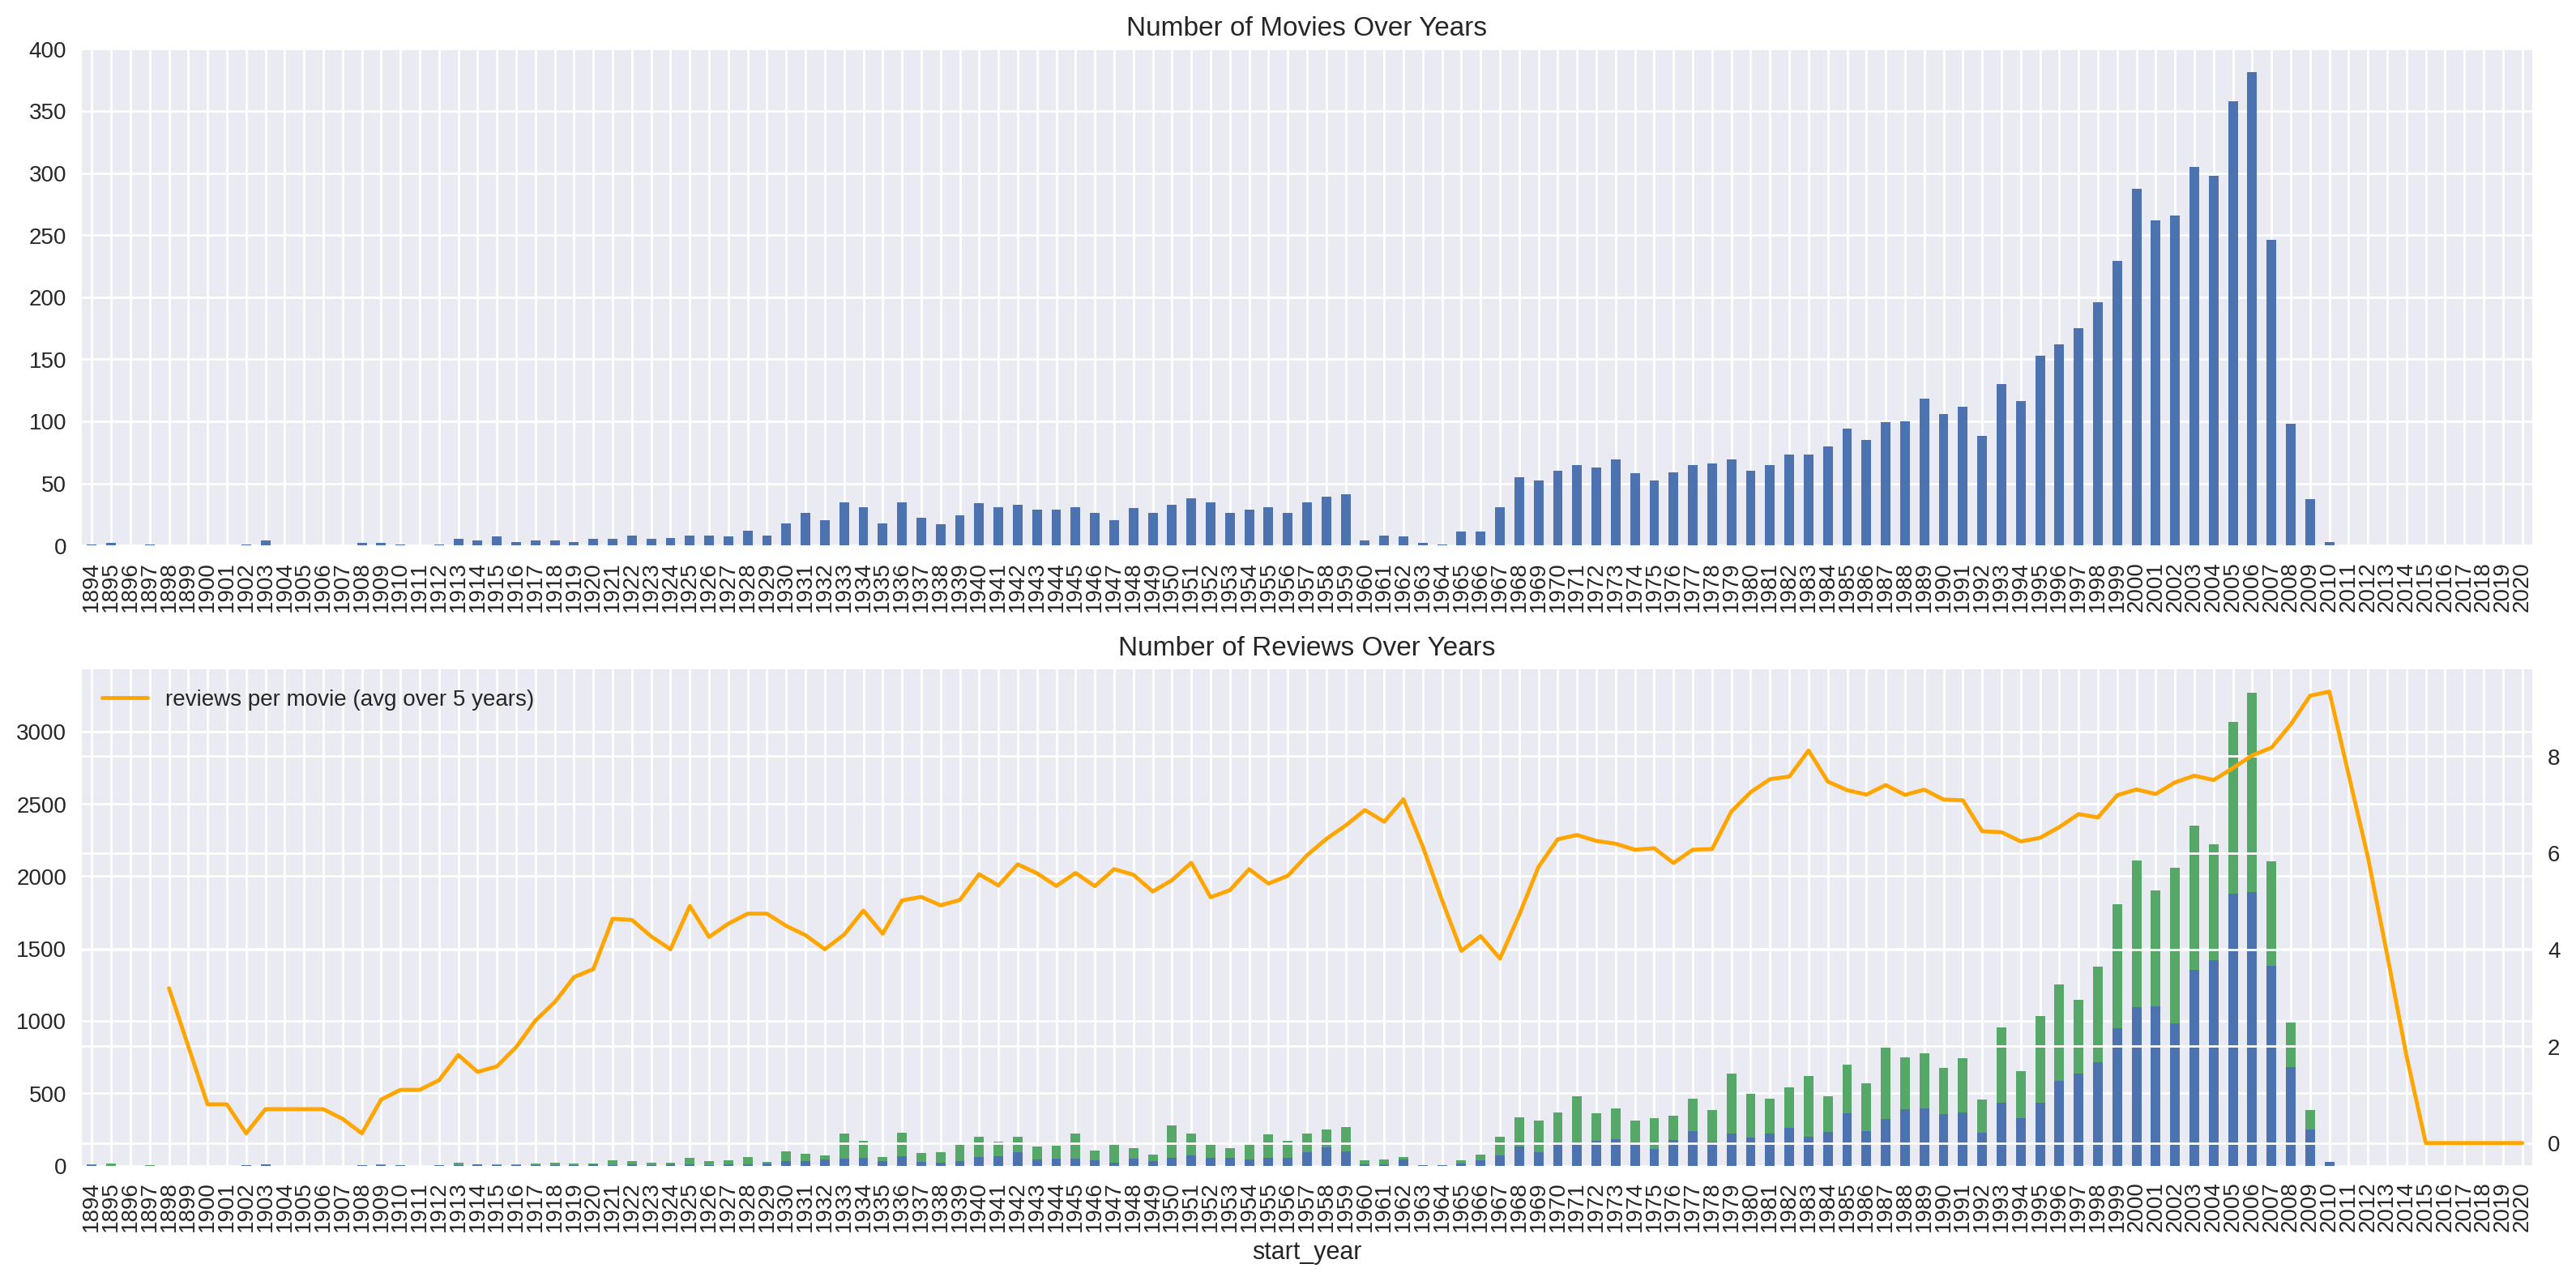

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
    
* Top Chart
    * Checking the number of movies over the years
    * From the early 1900s through the 1950s very few movies appear in the dataset
    * The start of the 1960s was very low but through the later part of the 1960s and 1970s there is a gradual increase
    * A sharp rise occurs in the 1990s and early 2000s peaking around 2008-2010
    * After 2010 the number of movies drops off likely due to newer titles not yet accumulating enough revie3ws for inclusion in the dataset
    * Conclusion
        * The dataet contains a strong concentration of movies released from 1990-2010 and this should be kept in mind when evaluating review distributions or trends over time
* Bottom Chart
    * Number of reviews over years
    * The green and blue bars represent the number of reviews per year split by positive and negative sentiment
    * The oranage line shows the avergae number of reviews per movie smoothed over 5 years rolling average
    * Review counts follow a similiaer trend to movie counts peaking in the 2000s
    * The avergae reviews per movie remain relatively stable from the 1980s through 2010 ranging around 6-8 reviews per movie
    * In the early year pre 1960s reviews per movie were low and inconsistent likely due to fewer users reviewing old films
    * Conclusion:
        * The number of reviews grows proportionally with the number of movies until approximately 2010
        * The orange line confirms that review coverage per movie is fairly stable across the peak period 1985-2010 meaning the dataset is not biased toward over reviewing recent titles
        * After 2010 there is a drop in both metrics likely due to incomplete coverage of newer titles
    
    
* Dataset is richest between 1990 and 2010 both in terms of movie count and review volume
* There is no strong temporal bias in sentiment as both classes grow evenly
* The average reviews per movie helps validate the datasets consistency across time
    

</div>

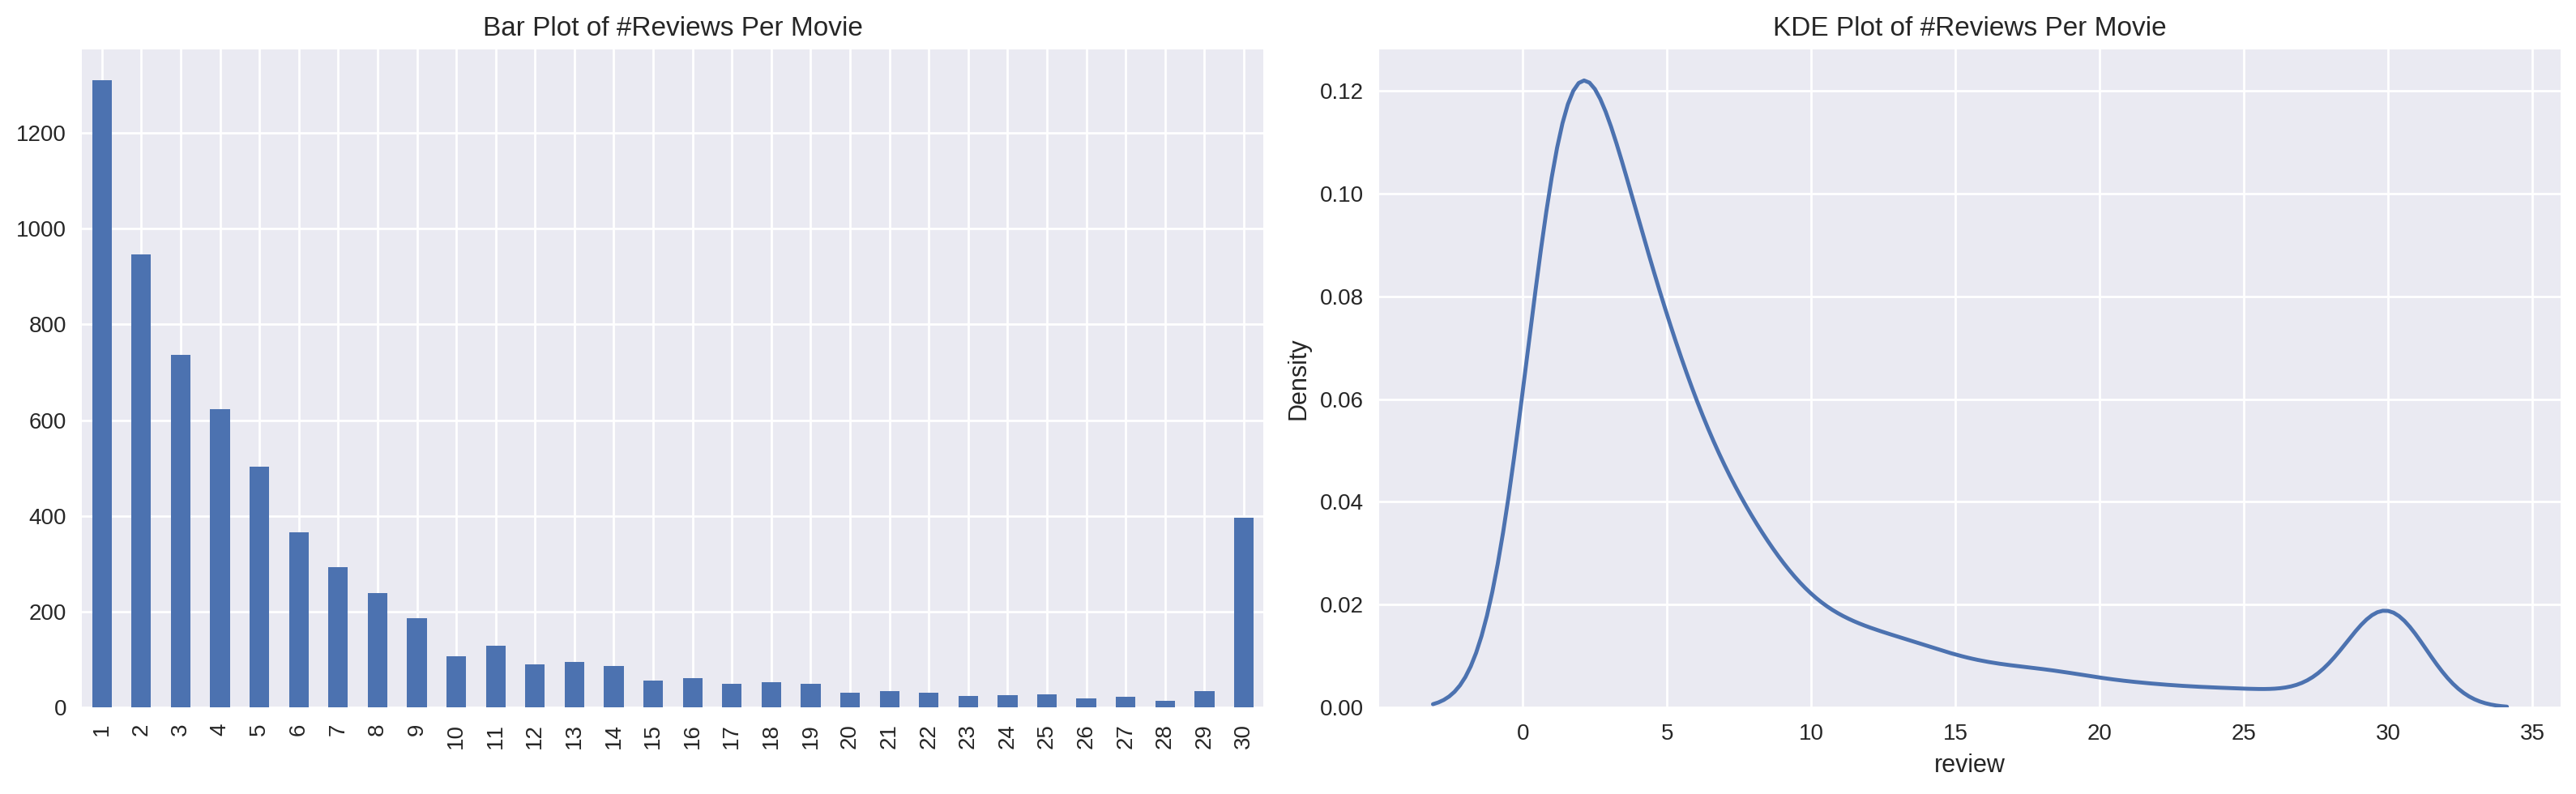

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Checking the distrbution of number of reviews per movie with the exact counting and KDE
* Bar Plot (Exact Counts):
    * The majority of movies have only 1-3 reviews with a steep drop off afterward
    * The number of movies with 10 or more reviews decreases rapidly
    * There is a noticeable spike at 30 reviews which likely indicates that some movies were capped at 30 reviews. The cap was already present in the dataset when it was loaded
* KDE Plot (Smoothed Distribution):
    * The KDE curve confirms the strong right skew in review counts
    * Most density is concentrated around 1-3 reviews per movie
    * A small secondary bump near 30 reviews further supports the presence of a review cap for some titles
* Conclusion:
    * The dataset contains a large number of sparsely reviewed movies with most titles having only one or three reviews. A small subset of movies appears to have been intentionally limited to 30 reviews which could introduce minor smapling bias. This distribution is important to consider when interpresting sentiment patterns or training models that rely on multiple reviews per movie
    

</div>

In [33]:
df_reviews['pos'].value_counts()

0    23680
1    23562
Name: pos, dtype: int64

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* The dataset is almost perfectly balanced between negative and positive reviews. The difference is only 1180 reviews less than 0.25% imbalance confirming there is no need for class rebalancing during model training
    

</div>

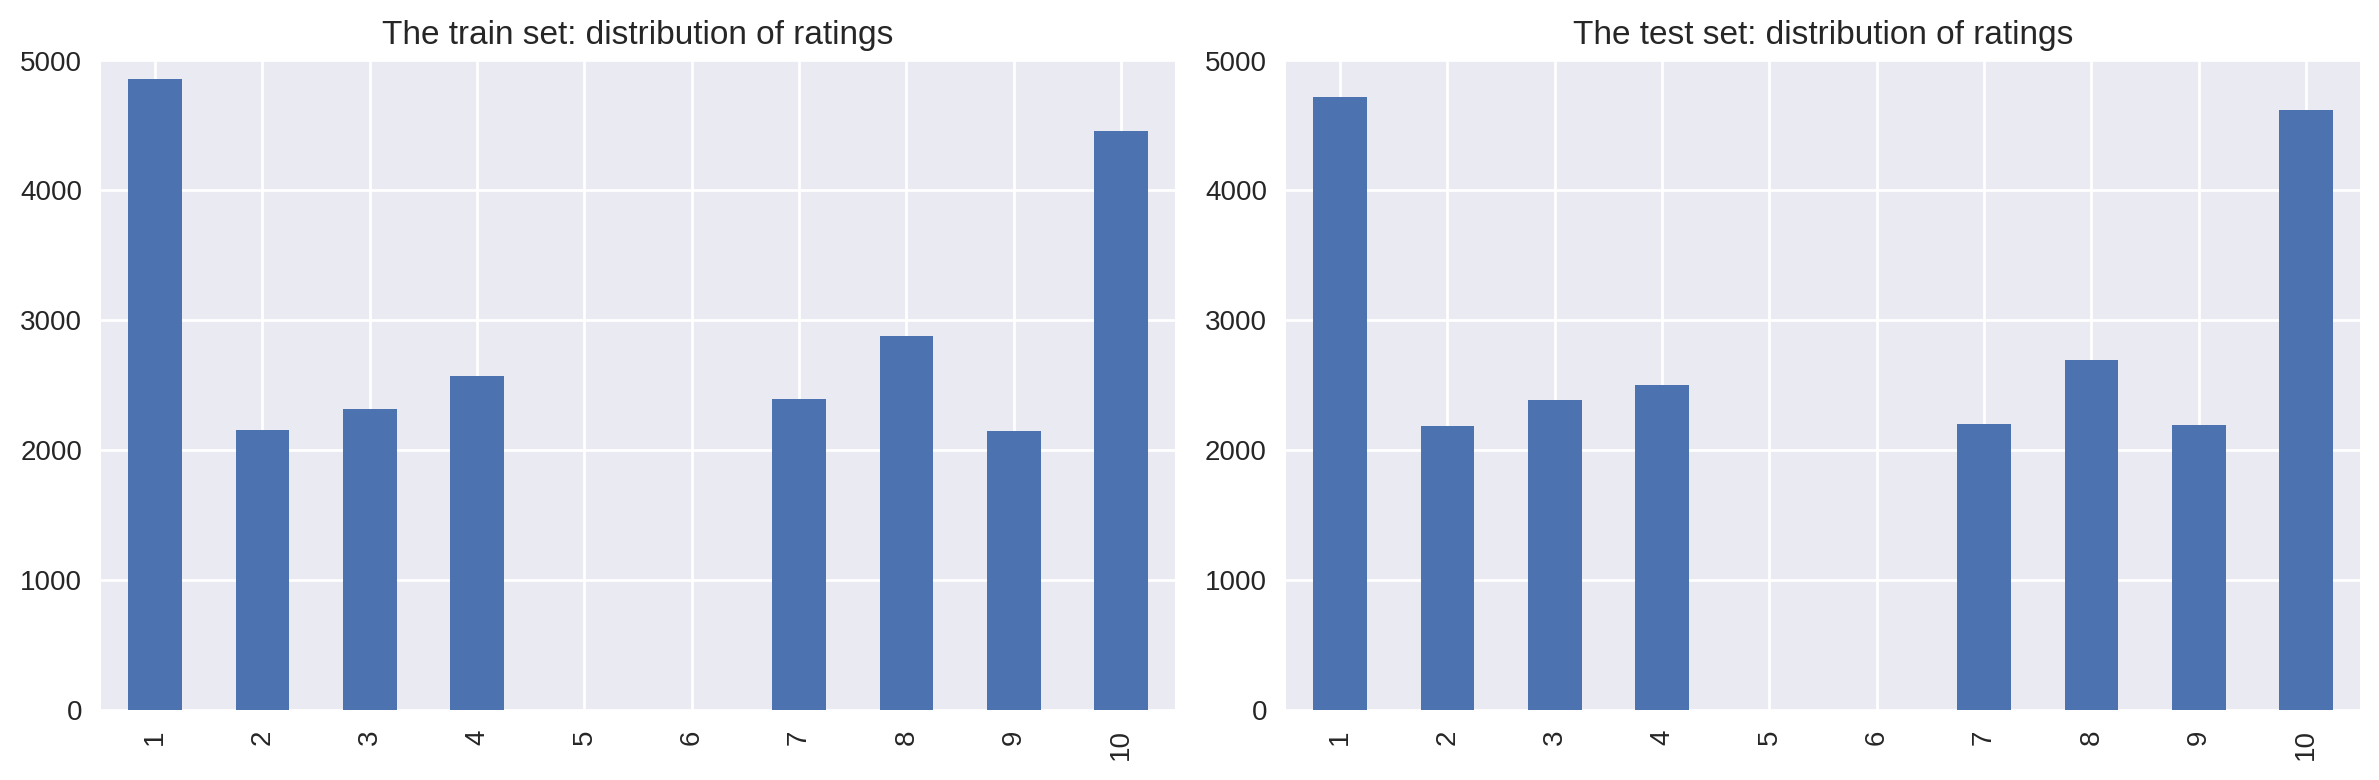

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Distribution of negative and positive reviews over the years for two parts of the dataset (Train and Test Sets)
* Key observations for both sets:
    * Ratings 1 and 10 dominate. The mos tfrequent ratings are 1 (lowest) and 10 (highest) in both train and test ssets suggesting a strong polarization in how users rate movies. Users are more likely to leave a review if they loved or hated a film
    * Ratings 2-9 are present but appear less frequently
    * Ratings 5 and 6 are either very low or absent likely flitered or sparsely represented in this dataset
    * The two distributions are visually similar meaning the train/test split maintained the original distribution of user ratings which is good as it ensure the model will not be surprised by new rating patterns during testing
* Conclusion:
    * The dataset shows bimodal rating distribution heavily skewed toward 1 and 10 consistent with real world review behavior. People tend to review when they feel strongly
    * The train and test sets are well maintained in rating distribution indicating a fair and represnetative split
    * This polarization may influence sentiment with 1 most likely relfecting negative rating and 10 likely a positive rating but since pos is a seperate label the model will still learn based on review text not just the numerical rating
    

</div>

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


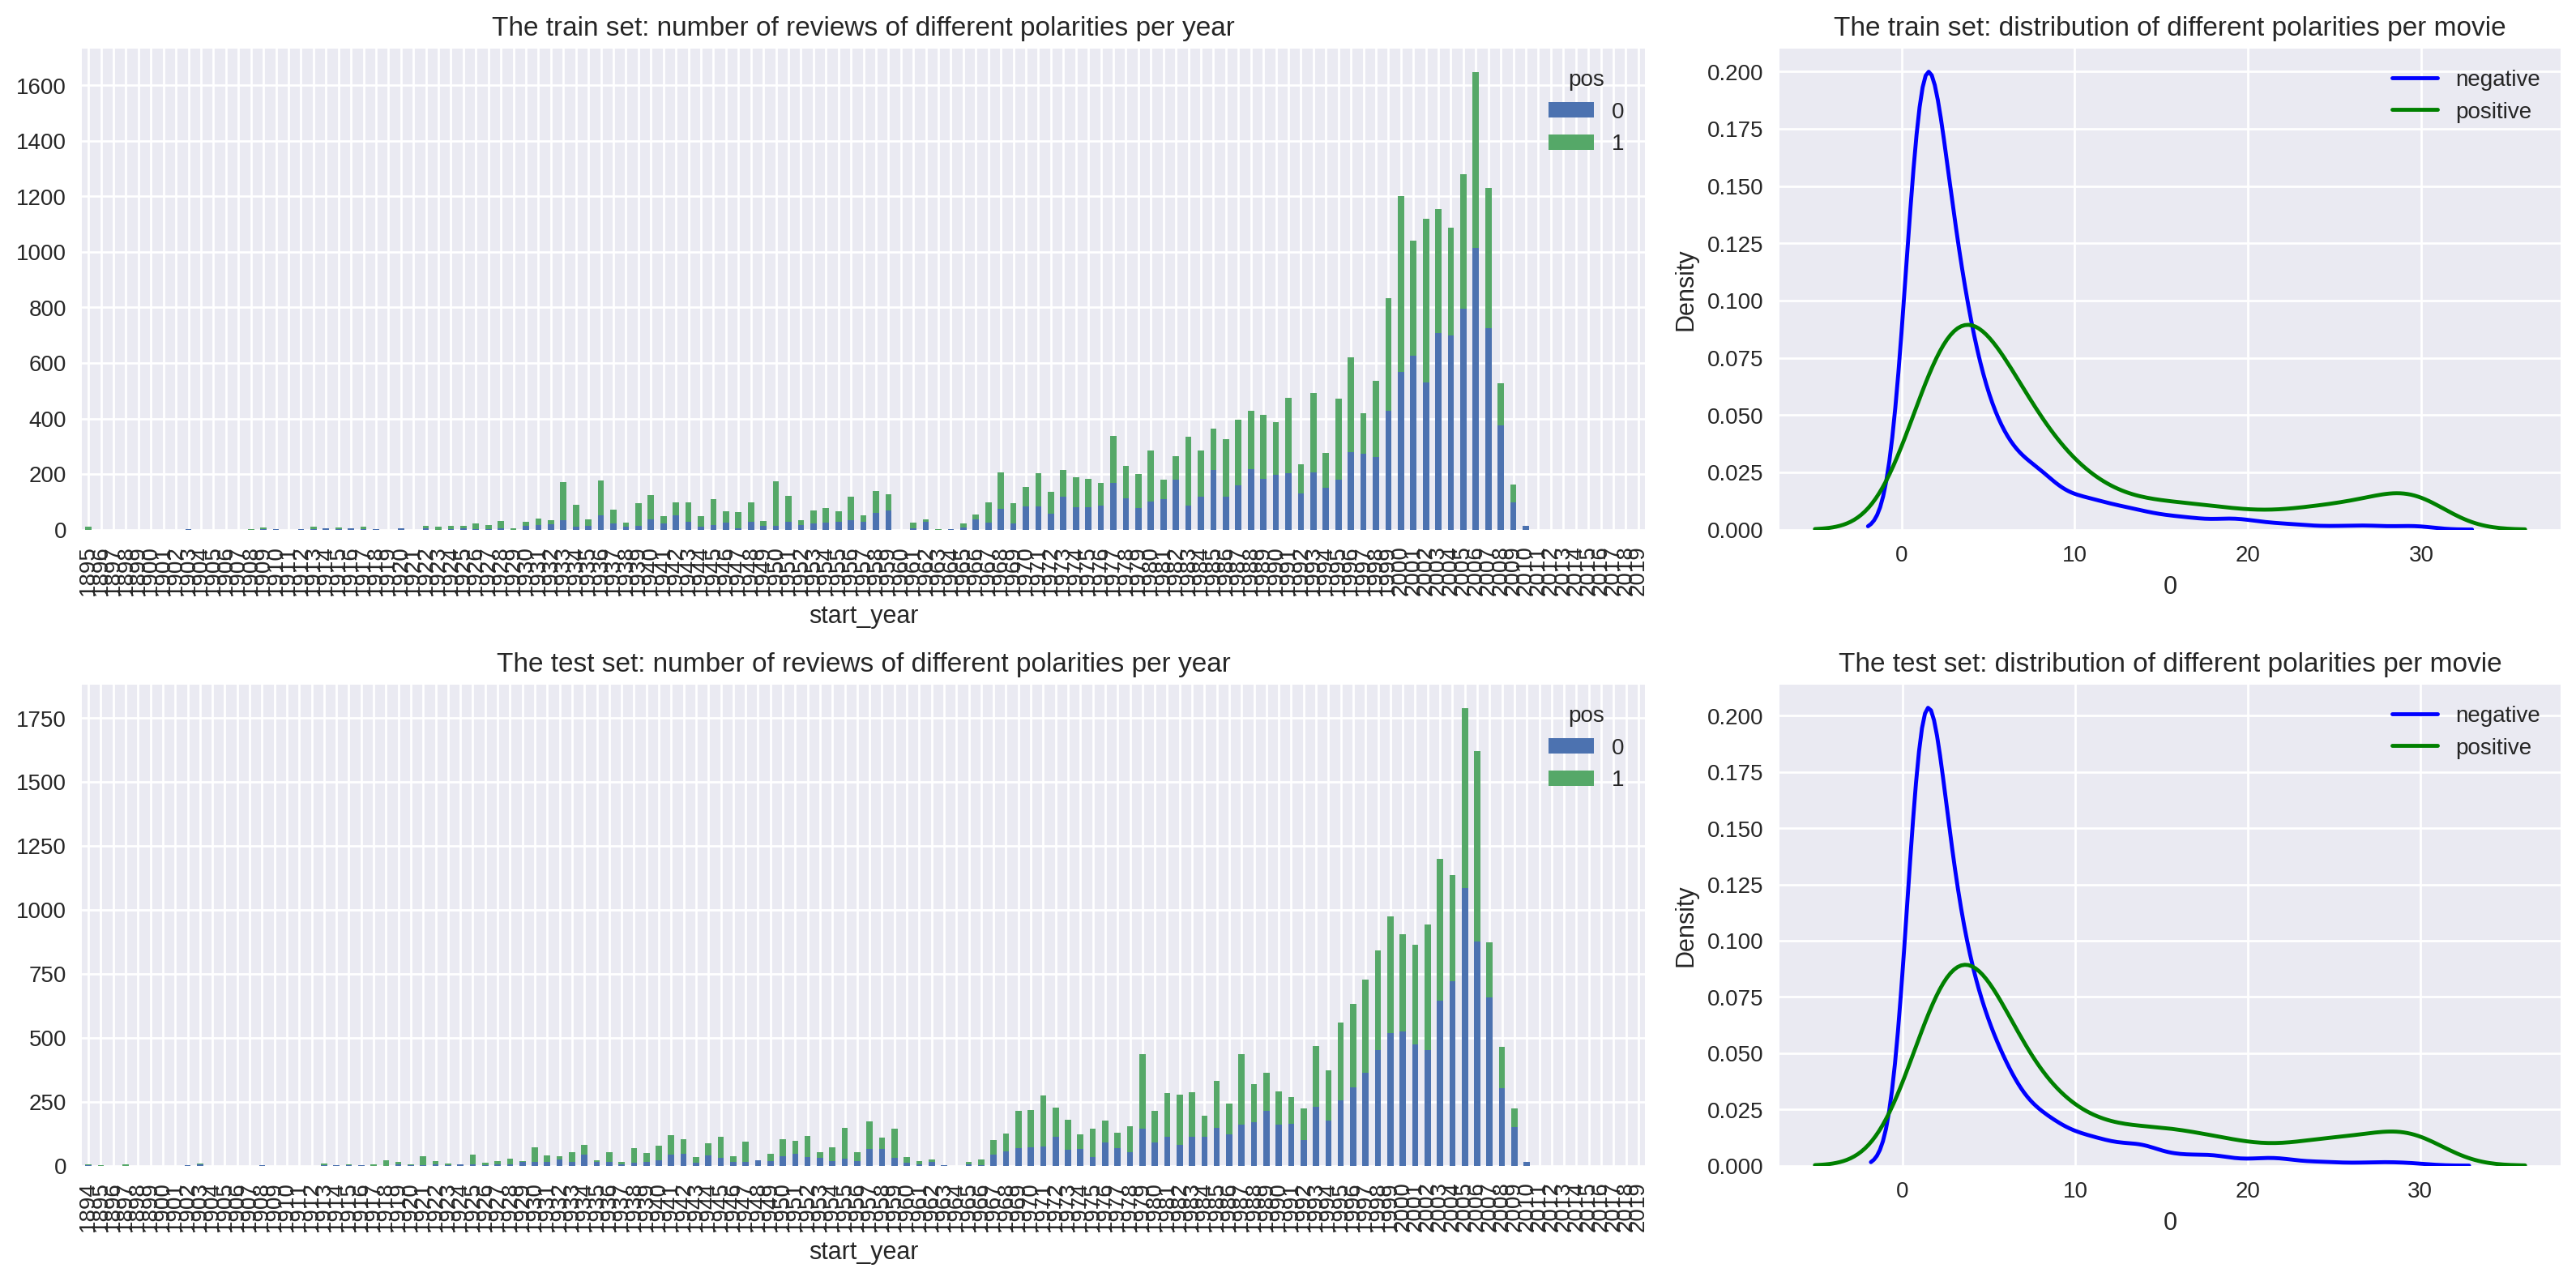

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Visualizing sentiment (pos) distributions across time and per movie separated for the train and test sets
* Train Set - Top Row
    * Top Left - Number of reviews of different polarities per year
        * There is a steady increase in review volume from the 1970s peaking between 1995-2010 followed by a drop post 2010
        * Positive and negative reviews are distributed fairly evenly across the timeline with no major class dominance in any given year
    * Top Right - Polarity distribution per movie
        * Most movies have only 1-3 reviews whether positive or negative a sharp spike is seen at low counts
        * There is a secondary bump around 30 reviews more noticable in the positive curve which again suggest a review cap likely at 30 per movie
* Test Set - Bottom Row
    * Bottom Left - Number of reviews of different polarities per year
        * Similiar trend to the train set review counts grow from the 1980s to a peak around 2010
        * Positive and negative reviews are again well balanced over time showing no year specific sentiment bias
        * The distribution over time aligns closely with the train set supporting that the split was done fairly and representatively
    * Bottom Right - Polarity distribution per movie
        * Again most movies have few reviews with the highest peak occuring at 1-3 reviews
        * The test set also shows a bump at 30 reviews particuarly in positive reviews reinforcing the presense of a review cap in the dataset
        * Distribution shapes match the train set suggesting consistency in data sampling
* Summary and Key Insights:
    * The number of reviews by yer and sentiment is well balanced in both train and test sets
    * There is no strong class imbalance over time where. Positive and negative reviews grow together
    * Most movies have very few reviews but a small group hits the 30 review cap more noticeably among positive reviews
    * The train/test splits appear representative with similiar temporal and polarity distributions

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 4: DATA CLEANING AND PREPROCESSING</h2>

</div>

In [36]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text, method='basic'):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if method == 'nltk':
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    elif method == 'spacy':
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        return ' '.join(tokens)

    return text

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Loading spaCy model
* Deifning the preprocessing function
    * Converting text to lowercase
    * Removing HTML tags
    * Removing non-alpanumeric characters
    * Removing extra spaces
* NLTK and spaCy Preprocessing
</div>

In [37]:
df_reviews['clean_review'] = df_reviews['review'].apply(lambda x: preprocess_text(x, method='basic'))
df_reviews['nltk_clean'] = df_reviews['review'].apply(lambda x: preprocess_text(x, method='nltk'))
df_reviews['spacy_clean'] = df_reviews['review'].apply(lambda x: preprocess_text(x, method='spacy'))

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Applying preprocessing
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 5: TRAIN/TEST SPLIT</h2>

</div>

In [38]:
train_data = df_reviews.query('ds_part == "train"')
test_data = df_reviews.query('ds_part == "test"')
train_target = train_data['pos']
test_target = test_data['pos']
print(f"Training Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (23759, 20)
Test Data Shape: (23483, 20)


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Data splitting

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 6: VECTORIZATION</h2>

In [39]:
def apply_vectorizer(train_texts, test_texts, max_features=10000):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))
    train_features = vectorizer.fit_transform(train_texts)
    test_features = vectorizer.transform(test_texts)
    return train_features, test_features, vectorizer

train_features_nltk, test_features_nltk, vectorizer_nltk = apply_vectorizer(train_data['nltk_clean'], test_data['nltk_clean'])

train_features_spacy, test_features_spacy, vectorizer_spacy = apply_vectorizer(train_data['spacy_clean'], test_data['spacy_clean'])

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Defining vectorizer function, TF-IDF vectorization with NLTK preprocessing, and TF-IDF vectorization with spaCy preprocessing

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 7: HYPERPARAMETER TUNING AND MODEL TRAINING</h2>

</div>

In [40]:
print("\nTraining Logistic Regression Model using NLTK Preprocessed Data...")
logreg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [1000, 1500],
    'solver': ['liblinear', 'lbfgs']
}

logreg_nltk = LogisticRegression(random_state=42)
grid_search_logreg_nltk = GridSearchCV(logreg_nltk, logreg_params, cv=3, scoring='f1', n_jobs=-1)
grid_search_logreg_nltk.fit(train_features_nltk, train_target)

model_logreg_nltk = grid_search_logreg_nltk.best_estimator_
print(f"Best Logistic Regression Parameters (NLTK): {grid_search_logreg_nltk.best_params_}")


Training Logistic Regression Model using NLTK Preprocessed Data...
Best Logistic Regression Parameters (NLTK): {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Hyperparameter tuning and model training for Logistic Regression Model using NLTK preprocessing

</div>

In [41]:
print("\nTraining Logistic Regression Model using spaCy Preprocessed Data...")
logreg_spacy = LogisticRegression(random_state=42)
grid_search_logreg_spacy = GridSearchCV(logreg_spacy, logreg_params, cv=3, scoring='f1', n_jobs=-1)
grid_search_logreg_spacy.fit(train_features_spacy, train_target)

model_logreg_spacy = grid_search_logreg_spacy.best_estimator_
print(f"Best Logistic Regression Parameters (spaCy): {grid_search_logreg_spacy.best_params_}")


Training Logistic Regression Model using spaCy Preprocessed Data...
Best Logistic Regression Parameters (spaCy): {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Hyperparameter tuning and model training for Logistic Regression model using spaCy preprocessing

</div>

In [42]:
print("\nTraining LGBM using spaCy Preprocessed Data...")
lgbm_params = {'n_estimators': [100, 150], 'learning_rate': [0.01, 0.05], 'max_depth': [5, 7]}
lgbm_spacy = LGBMClassifier(random_state=42)
grid_search_lgbm = GridSearchCV(lgbm_spacy, lgbm_params, cv=3, scoring='f1', n_jobs=-1)
grid_search_lgbm.fit(train_features_spacy, train_target)

model_lgbm = grid_search_lgbm.best_estimator_
print(f"Best LGBM Parameters: {grid_search_lgbm.best_params_}")


Training LGBM using spaCy Preprocessed Data...
Best LGBM Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 150}


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Hyperparameter tuning and model training for LGBM model using spaCy preprocessing

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 8: ENSEMBLE IMPLEMENTATION</h2>

</div>

In [43]:
logreg_nltk_preds = model_logreg_nltk.predict_proba(test_features_nltk)[:, 1]
logreg_spacy_preds = model_logreg_spacy.predict_proba(test_features_spacy)[:, 1]
lgbm_spacy_preds = model_lgbm.predict_proba(test_features_spacy)[:, 1]

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Generating probability prediction for test dataset using the following three trained models:
    * Logistic Regression with NLTK Preprocessing (logreg_nltk)
    * Logistic Regression with spaCy Preprocessing (logreg_spacy)
    * LGBM with spaCy Preprocessing (lgbm_spacy)

</div>

In [44]:
logreg_weight = 0.6
lgbm_weight = 0.4

if logreg_weight + lgbm_weight != 1:
    raise ValueError("Ensemble weights must sum to 1.")

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Defining weights for the ensemble

</div>

In [45]:
ensemble_preds_spacy = (logreg_weight * logreg_spacy_preds) + (lgbm_weight * lgbm_spacy_preds)
ensemble_preds_spacy_binary = (ensemble_preds_spacy >= 0.5).astype(int)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Combining predictions from two models Logistic Regression (spaCy preprocessing) and LGBM (spaCy preprocessing) to create an ensemble prediction

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 9: MODEL EVALUATION FUNCTION</h2>

</div>

In [46]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    # Iterate over train and test sets
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        # Predictions
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1 Score Calculation
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        
        # ROC Curve Calculation
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Precision-Recall Curve Calculation
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        # Color for plots
        color = 'blue' if type == 'train' else 'green'

        # F1 Score Plot
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type} max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Adding Markers for Specific Thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(f1_thresholds[closest_idx], f1_scores[closest_idx], marker='X', markersize=7, color=marker_color)
        
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.set_title('F1 Score')
        ax.legend()

        # ROC Curve Plot
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type} ROC AUC={roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(fpr[closest_idx], tpr[closest_idx], marker='X', markersize=7, color=marker_color)

        ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve')
        ax.legend()

        # PRC Curve Plot
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type} APS={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            if len(pr_thresholds) == 0:
                continue  # Avoid index error if no thresholds
            closest_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(recall[closest_idx], precision[closest_idx], marker='X', markersize=7, color=marker_color)

        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend()

        # Collect evaluation metrics
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    # Display evaluation metrics
    df_eval_stats = pd.DataFrame(eval_stats).round(2).reindex(['Accuracy', 'F1', 'APS', 'ROC AUC'])
    print(df_eval_stats)
    
    plt.tight_layout()
    plt.show()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Composing an evaluation routine which can be used for all models in this project
* This reusable evaluation function takes any classifier that supports `predict()` and `predict_proba()` methods and evaluates it on both train and test sets using Accuracy, F1 Score, ROC AUC, and Average Precision Score. It also produces visual diagnostics to compare performance across thresholds

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 10: WORKING WITH MODELS</h2>

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>MODEL 0 - CONSTANT</h2> 

</div>

In [47]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_data['clean_review'])
X_test = vectorizer.transform(test_data['clean_review'])

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Model 0 - Constant Classifier (Baseline Model)
* This model predicts the most frequent class (majority class) as the baseline for comparison
* Vectorization using Basic Preprocessing (clean_review)


</div>


Evaluating Model 0 - Constant Classifier (Baseline)...
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


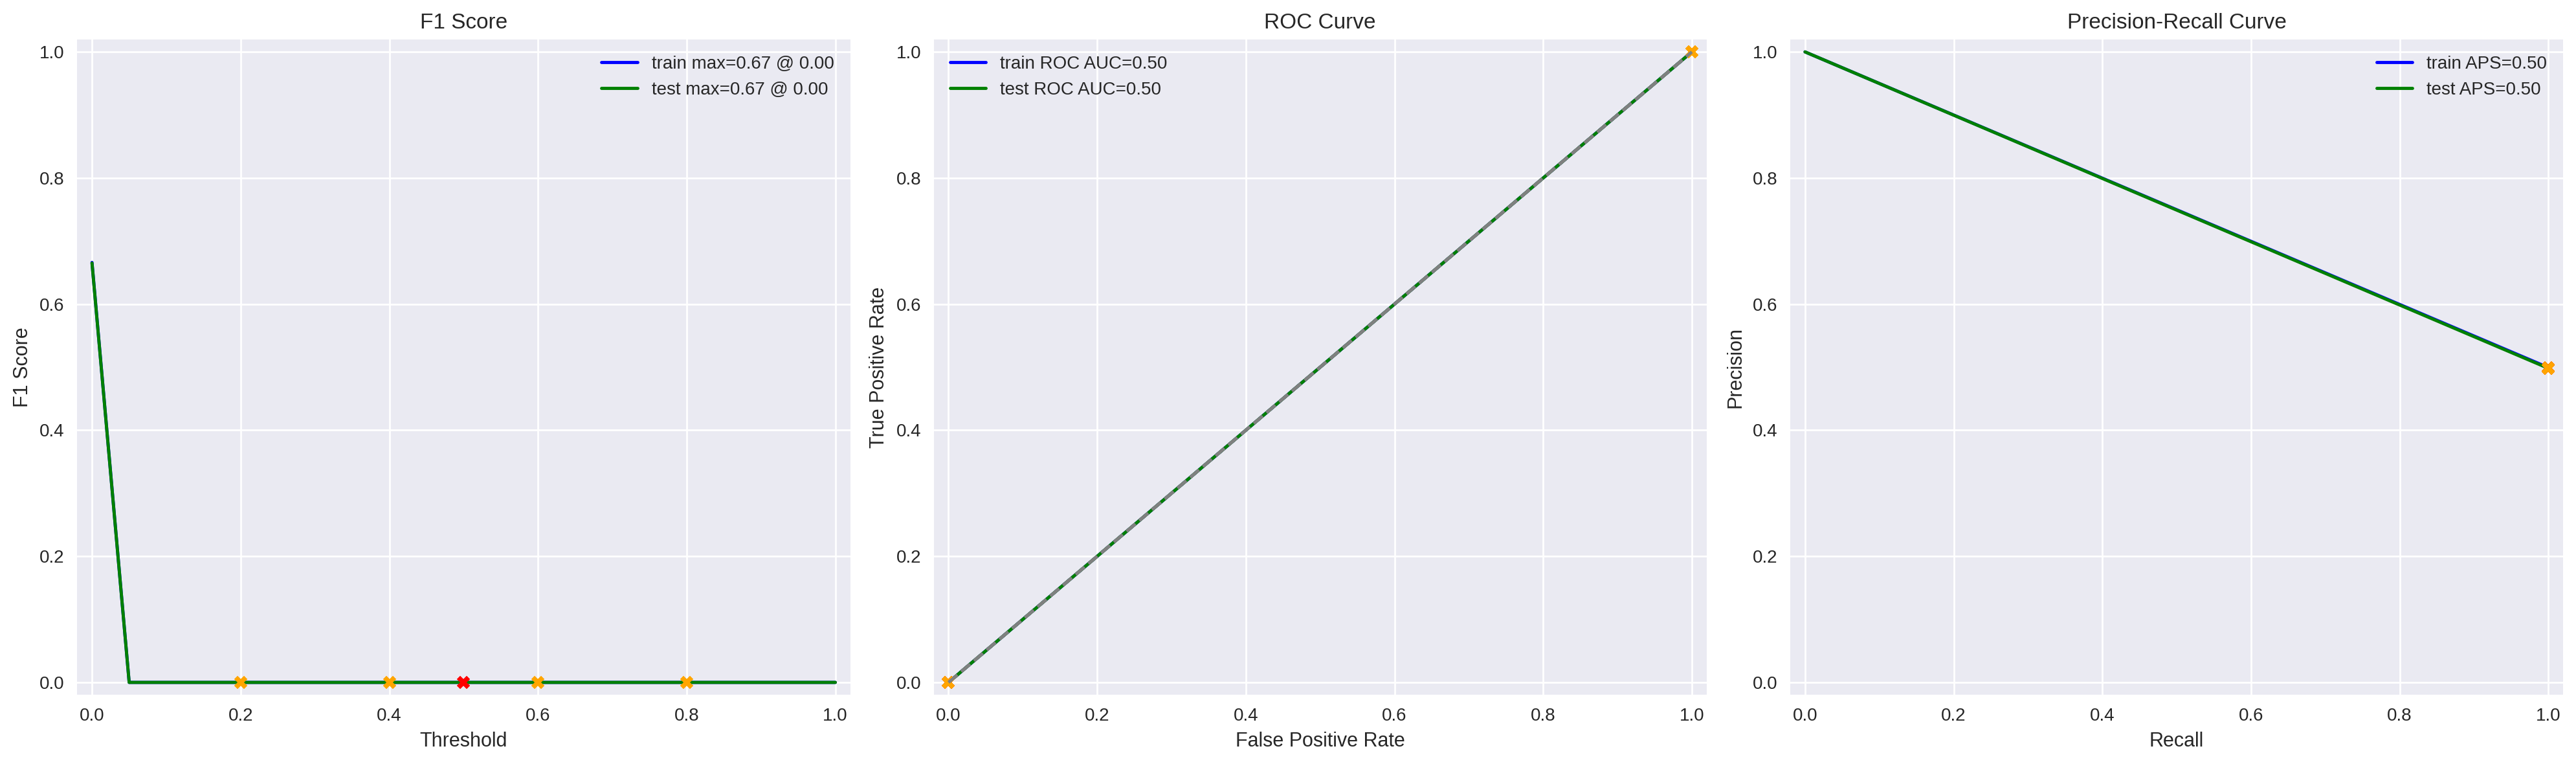

In [48]:
model_0 = DummyClassifier(strategy='most_frequent', random_state=42)
model_0.fit(X_train, train_target)

print("\nEvaluating Model 0 - Constant Classifier (Baseline)...")
evaluate_model(model_0, X_train, train_target, X_test, test_target)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Initializing and training Model 0 - Constant Classifier    
* Evaluating Model 0 - Constant Classifier using evaluation function
* Evaluation Metrics:
    * Accuracy - The model classifies 50% of the instances in both the training and testing datasets. Since the model always predicts the majority classs the accuracy simply reflects the majority class proportion in the dataset
    * F1 Score - The F1 score is 0.0 because the model only predicts the majority class resulting in no true positives or false positives for the minority class
    * APS - The APS is 0.5 indicating a model is as good as random guessing. This is consistent with a baseline model that makes constant predictions without learning from the data
    * ROC AUC - The ROC AUC score is 0.5 which is equivalent to random guessing. A perfectly random model produces a diagonal line in ROC plot and that is exactly what we can see here
* Plots Analysis:
    * F1 Sore vs Threshold
        * The F1 score r4emains at 0.0 across all thresholds indicating that the model is not capturing any positive class predicitions. The sudden drop to zero reflects the fact that the model is not making any meaningful positive predctions
    * ROC Curve Plot:
        * The ROC curve is a straight diagonal line representing a model that is no better than random guessing. This is typical for a baseline model that only predicts the majroity class without considering actual data distribution
    * Precision Recall Curve
        * The PRC curve is a straight line at 0.5 reflecting random guessing. Since the model only predicts the majority class precision and recall remain constant and provide no meaningful insights
* Conclusion:
    * The baseline Constant Classifier serves as a reference point to measure how much more effective the trained models (Logistic Regression and LGBM) are in comparison
    * The metrics clearly indicate that the baseline model is not learning from the data and simply outputs the majority class


</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>MODEL 1 - NLTK, TF-IDF and LR</h2> 

</div>

In [49]:
print("\nModel 1 - NLTK, TF-IDF, and Logistic Regression")

print("\nApplying NLTK Preprocessing...")
train_data['nltk_clean'] = train_data['review'].apply(lambda x: preprocess_text(x, method='nltk'))
test_data['nltk_clean'] = test_data['review'].apply(lambda x: preprocess_text(x, method='nltk'))

print("\nNLTK Preprocessing - Sample Output:")
print(train_data[['review', 'nltk_clean']].head())


Model 1 - NLTK, TF-IDF, and Logistic Regression

Applying NLTK Preprocessing...


/tmp/ipykernel_32/1691613415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['nltk_clean'] = train_data['review'].apply(lambda x: preprocess_text(x, method='nltk'))



NLTK Preprocessing - Sample Output:
                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
7  This true story of Carlson's Raiders is more o...   
8  Should have been titled 'Balderdash!' Little i...   
9  The movie 'Gung Ho!': The Story of Carlson's M...   

                                          nltk_clean  
0  pakage implies warren beatty goldie hawn pulli...  
1  hell get made presenting caper comedy misbegot...  
7  true story carlsons raider army training film ...  
8  titled balderdash little film true except name...  
9  movie gung ho story carlsons makin island raid...  


/tmp/ipykernel_32/1691613415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['nltk_clean'] = test_data['review'].apply(lambda x: preprocess_text(x, method='nltk'))


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Applying NLTK Preprocessing using preprocess_text() function

</div>


Evaluating Model 1 - NLTK + TF-IDF + Logistic Regression...
          train  test
Accuracy   0.93  0.89
F1         0.93  0.89
APS        0.98  0.95
ROC AUC    0.98  0.95


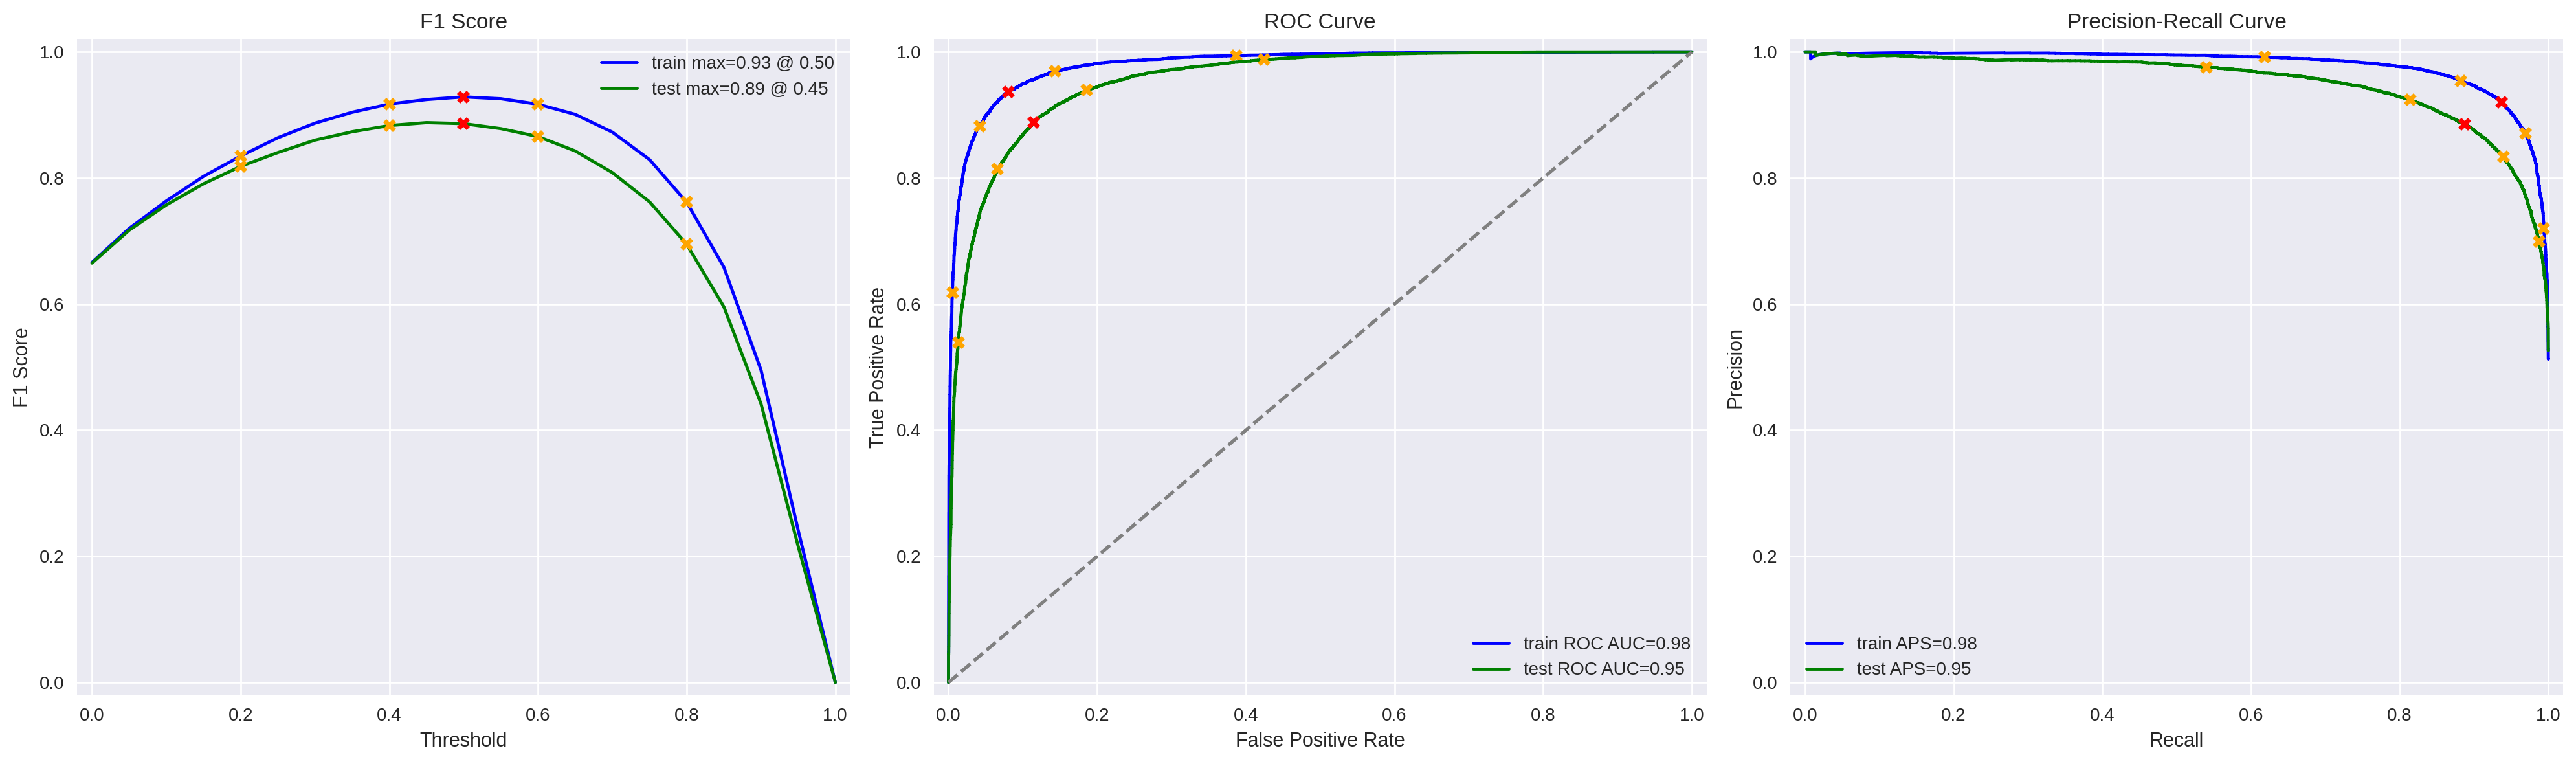

In [50]:
print("\nEvaluating Model 1 - NLTK + TF-IDF + Logistic Regression...")
evaluate_model(model_logreg_nltk, train_features_nltk, train_target, test_features_nltk, test_target)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Evaluating Model 1 - NLTK, TF-IDF and LR using evaluation function    
* Evaluation Metrics
    * Accuracy - The model demonstrates a strorng classification ability with high accuracy on both the training and testing datasets. The slight drop from 0.93 train to 0.89 test suggests minimal overfitting
    * F1 Score - The F1 score is quite high indicating a good balance between precision and recall. This is a significant improvement over the baseline model (0.0 F1 score)
    * APS - The APS score is very high indicating that the model is effectively ranking positive samples higher than negative samples. This is a key metric in imbalanced datasets and shows that the model is capturing positive class instances well
    * ROC AUC - The ROC AUC scores are exceptionally strong indicating that the model is very good at distinguishing between positive and negative classes
* Plot Analysis:
    * F1 Score Plot
        * The F1 Score curve is wellformed with a peak around 0.5 threshold. The F1 Score maintains high values throughout most of the threshold range indicating consistent performance across varying thresholds
    * ROC Curve Plot
        * The ROC curve is almost at the top left corner suggesting a model with excellent discriminative ability. The slight dip in the test set curve compared to the training curve indicates a small generalization gap but nothing concerning
    * Precision Recall Curve
        * The PRC curve is very close to the top right corner highlighting strong precision and recall across different thresholds. Both the train and test sets maintain high precision and recall reinforcing the robustness of the model
* Conclusion:
    * The NLTK + TF-IDF + Logistic Regression model significantly outperforms the baseline model across all metrics
    * The model achieves the project requirement of an F1 score of at least 0.85 with an actual F1 score of 0.89 on the test set
    * The minimal drop in accuracy, F1, and APS from train to test suggests that the model is wel generalized and not overfitting
    * The strong ROC AUC and PRC curves further confirm that the model is effectively distinguishing between positive and negative reviews

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>MODEL 2 - spaCy, TF-IDF and LR</h2> 

</div>

In [51]:
print("\nModel 2 - spaCy, TF-IDF, and Logistic Regression")

print(f"Best Logistic Regression Parameters (spaCy): {grid_search_logreg_spacy.best_params_}")


Model 2 - spaCy, TF-IDF, and Logistic Regression
Best Logistic Regression Parameters (spaCy): {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Displaying the best hyperparameters identified during tuning

</div>


Evaluating Model 2 - spaCy + TF-IDF + Logistic Regression...
          train  test
Accuracy   0.92  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


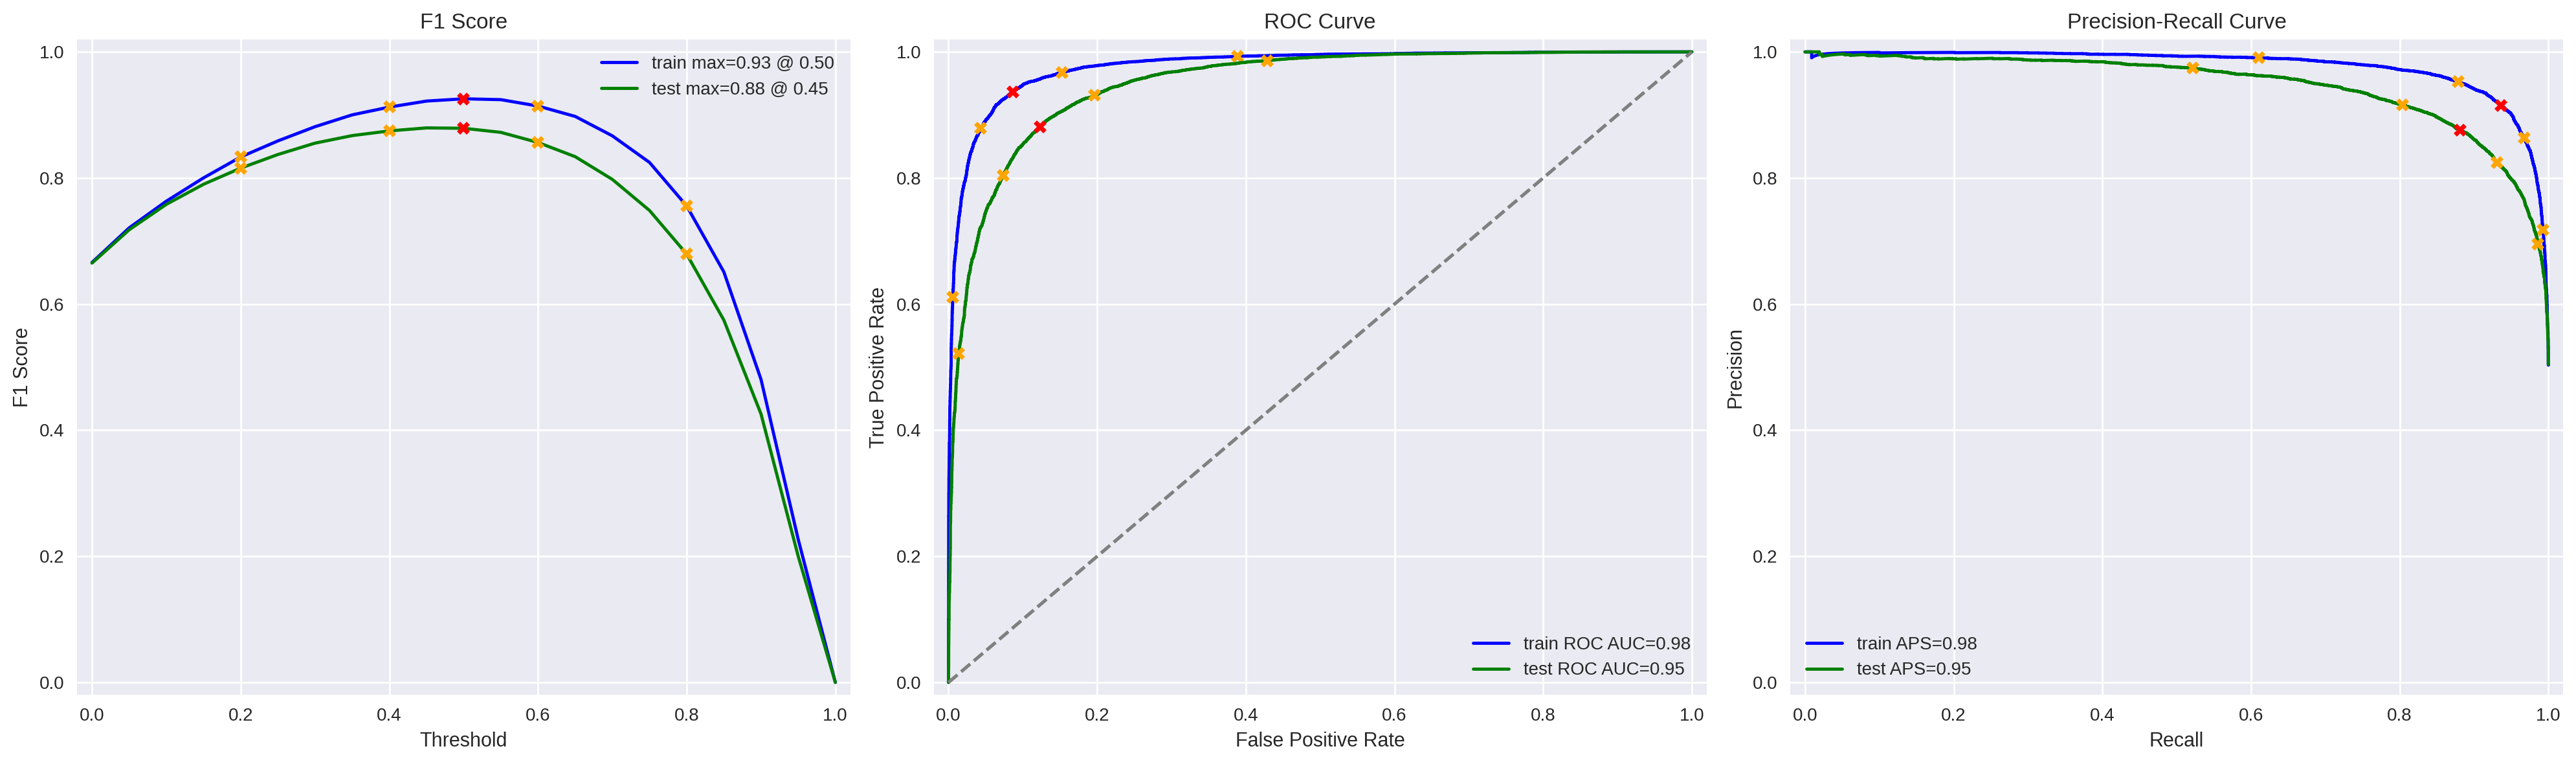

In [52]:
print("\nEvaluating Model 2 - spaCy + TF-IDF + Logistic Regression...")
evaluate_model(model_logreg_spacy, train_features_spacy, train_target, test_features_spacy, test_target)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Evaluating Model 2 - spaCy, TF-IDF and LR using evaluation function 
* Evaluation Metrics
    * Accuracy - The model exhibits slightly lower accuracy compared to Model 1 (NLTK + TF-IDF + Logistic Regression). The train/test gap is minimal suggesting good generalization
    * F1 Score - The F1 score on the test set 0.88 is slightly lower than the NLTK model 0.89. This minor drop could indicate that the spaCy preprocessing method did not contribute significantly to enhancing classification performance in this context
    * APS - APS remains high and consistent similar to Model 1. This consistency indicates that the model effectively maintains precision and recall across different decision thresholds
    * ROC AUC - ROC AUC values are strong indicating robust discriminatory power between positive and negative reviews
* Plot Analysis
    * F1 Score vs Threshold Plot
        * The F1 Score curve is similar to Model 1 peaking around a threshold of 0.5. The curve remains stable across different thresholds indicating consistent performance
    * ROC Curve Plot
        * The ROC curve is almost identical to that of Model 1 hugging the top left corner closely. This is a positive indication of model performance
    * Precision Recall Curve
        * The PRC curve is highly consistent and very close to the top right corner indicating strong precision recall trade off across different thresholds
* Conclusion
    * Accuracy and F1 Score - Model 1 (NLTK) slightly outperforms Model 2 (spaCy) in terms of accuracy and F1 score though the difference is marginal
    * APS and ROC AUC - Both models exhibit nearly identical APS and ROC AUC scores indicating comparable ranking and discrimination capabilities
    * The spaCy preprocessing method did not provide a significant performance boost over the NLTK method
    * Considering the slightly longer runtime for spaCy due to lemmatization the NLTK approach may be preferred unless the text data is more complex requiring advanced linguistic processing
    

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>MODEL 3 - spaCy, TF-IDF and LGBMClassifier</h2> 

</div>

In [53]:
print("\nModel 3 - spaCy, TF-IDF, and LGBMClassifier")

print(f"Best LGBM Parameters (spaCy): {grid_search_lgbm.best_params_}")


Model 3 - spaCy, TF-IDF, and LGBMClassifier
Best LGBM Parameters (spaCy): {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 150}


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Displaying the best hyperparameters identified during tuning

</div>


Evaluating Model 3 - spaCy + TF-IDF + LGBMClassifier...
          train  test
Accuracy   0.87  0.83
F1         0.87  0.83
APS        0.94  0.91
ROC AUC    0.94  0.91


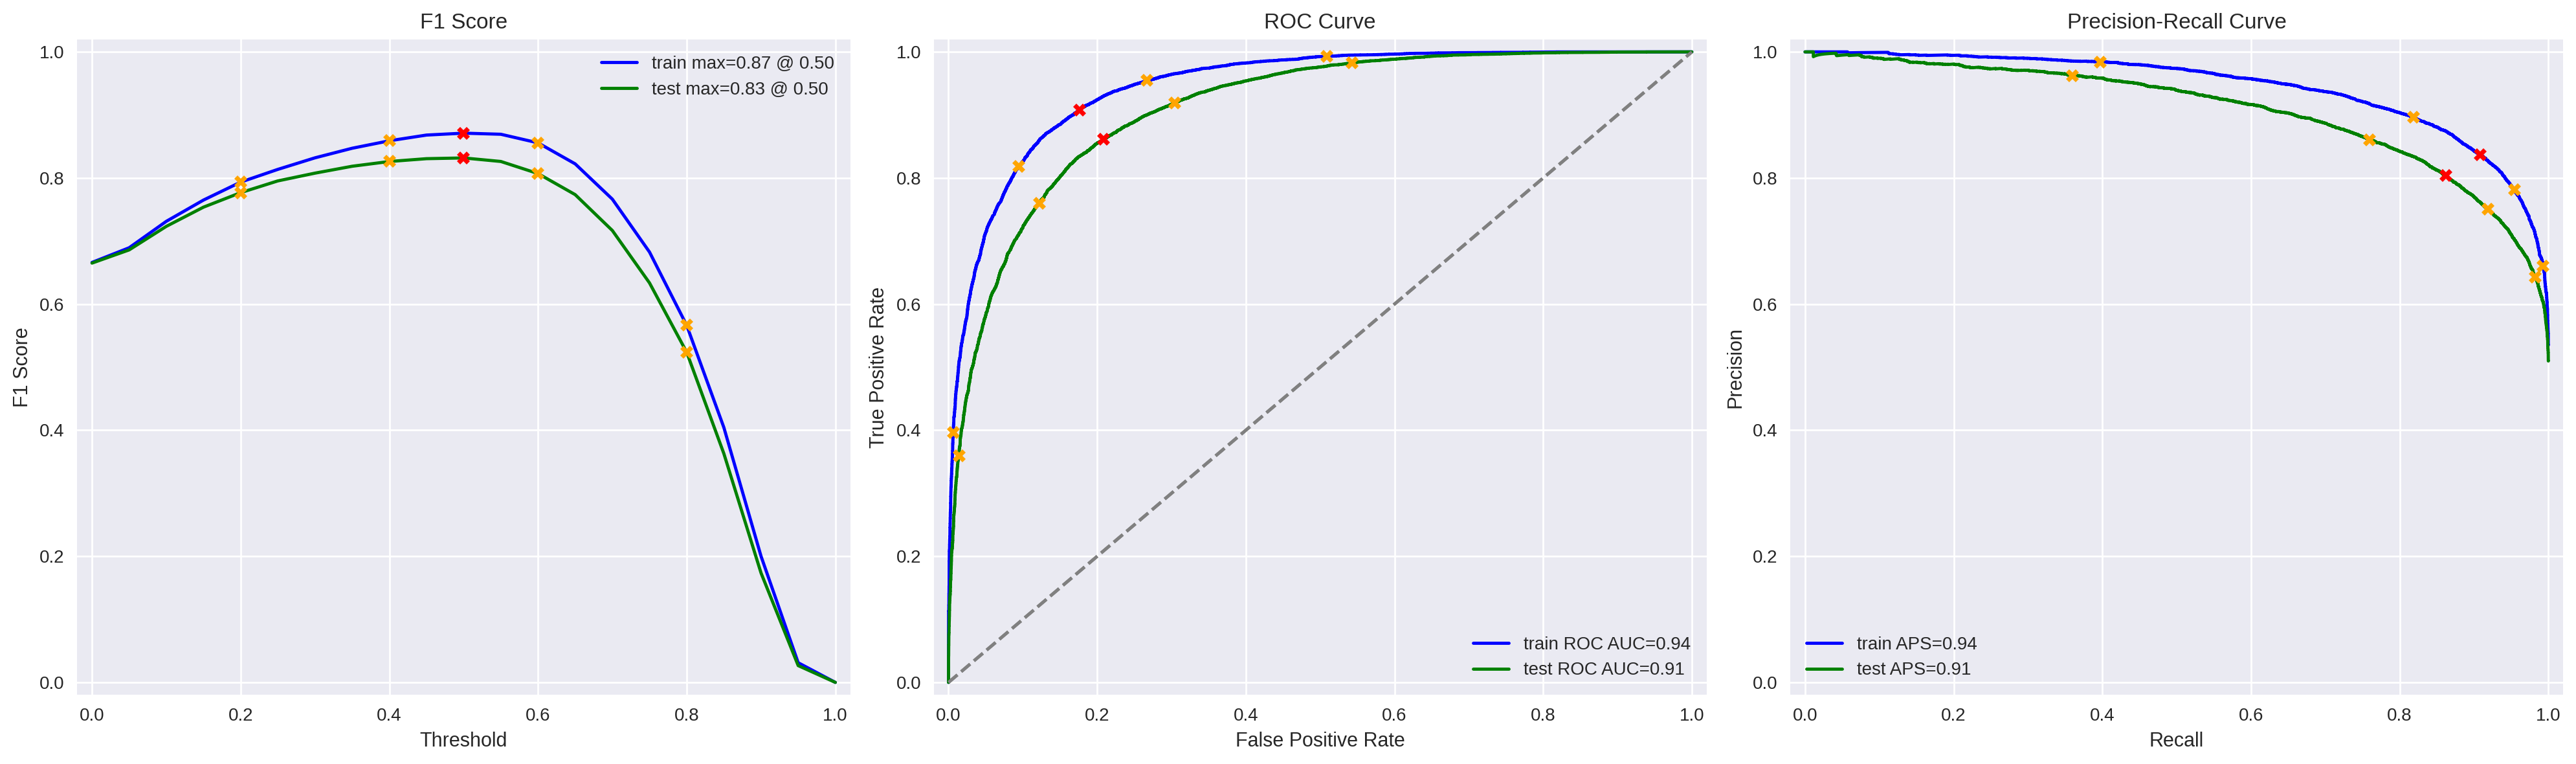

In [54]:
print("\nEvaluating Model 3 - spaCy + TF-IDF + LGBMClassifier...")
evaluate_model(model_lgbm, train_features_spacy, train_target, test_features_spacy, test_target)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Evaluating Model 3 - spaCy, TF-IDF and LGBMClassifier using evaluation function
* Evaluation Metrics
    * Accuracy - The LGBM model shows a slight drop in accuracy compared to both the NLTK and spaCy Logistic Regression models. This decrease suggests that the model is potentially overfitting or less effective in generalizing on the test set
    * F1 Score - The F1 score is slightly lower than the Logistic Regression models. LGBM is typically good at handling imbalanced datasets but in this case the simpler models (Logistic Regression) outperformed it slightly in terms of F1 score
    * APS - APS is still quite strong indicating that the model maintains reasonable precision and recall trade offs. However it is slightly lower than the previous models indicating less effective separation between classes
    * ROC AUC - ROC AUC values indicate that the model is fairly good at distinguishing between positive and negative reviews. However the ROC AUC is lower than in the previous two models suggesting that the LGBM model is not as effective in ranking predictions
* Plots Analysis
    * F1 Score vs Threshold Plot
        * The F1 Score curve peaks around a threshold of 0.5 similar to previous models. However, the curve drops more sharply after the peak indicating that the model may not be as robust to threshold changes as the logistic regression models
    * ROC Curve Plot
        * The ROC curve still maintains a good curve shape but is slightly less steep than the previous models. The ROC AUC values are strong but indicate slightly less effective classification compared to the logistic regression models
    * Precision Recall Curve
        * The PRC curve is still well positioned though it dips more noticeably as recall increases. This suggests that while the model maintains good precision it struggles slightly with recall particularly at higher recall thresholds
* Conclusion
    * Accuracy and F1 Score - Model 3 (LGBM) has lower accuracy and F1 scores compared to both NLTK + LR and spaCy + LR models. This is unexpected as LGBM is generally more powerful but it may indicate that the logistic regression models are more suitable for this dataset
    * APS and ROC AUC - The APS and ROC AUC scores are still high though slightly lower than the logistic regression models suggesting that LGBM struggled slightly in achieving as strong a separation between positive and negative classes
    * The LGBM model despite being more advanced and complex did not outperform the simpler logistic regression models in this particular dataset. This outcome may indicate that the text data is well suited to linear classification methods or that the LGBM model might require further tuning to reach optimal performance
    

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Performance Analaysis Summary:
    * Model 0 - Constant Classifier (Baseline):
        * This model serves as a baseline and always predicts the majority class. The metrics are as expected: accuracy of 0.5, F1 score of 0.0, and AUC of 0.5 indicating that it is effectively random and holds no predictive power
    * Model 1 - NLTK + TF-IDF + Logistic Regression:
        * This model achieved the highest overall performance with a test accuracy of 0.89 and F1 score of 0.89. The ROC AUC of 0.95 is excellent indicating that the model is highly effective at distinguishing between positive and negative reviews. The precision recall curve also suggests a balanced trade off maintaining high precision and recall at various thresholds. The model is well calibrated and performs robustly with minimal overfitting making it a strong candidate for deployment
    * Model 2 - spaCy + TF-IDF + Logistic Regression:
        * Similar performance to Model 1 with only a slight drop in accuracy and F1 score (0.88). ROC AUC remains strong at 0.95 indicating that spaCy's lemmatization and preprocessing are comparable to NLTK's. The slight performance drop could indicate that NLTK's preprocessing method may be slightly more effective in this dataset context
    * Model 3 - spaCy + TF-IDF + LGBMClassifier:
        * Despite being a more advanced model LGBM underperformed compared to the logistic regression models. The test accuracy of 0.83 and F1 score of 0.83 are noticeably lower and the model appears to struggle slightly with overfitting. The ROC AUC and APS are also slightly lower indicating that LGBM is less effective in ranking positive and negative classes
* **Model Recommendation:**
    * Based on the above analysis the recommended model for deployment is **Model 1 - NLTK + TF-IDF + Logistic Regression**
        * It consistently demonstrated the highest accuracy, F1 score, and ROC AUC values across both the training and testing datasets
        * The model is simple, interpretable, and computationally efficient making it ideal for implementation and potential scalability
        * The preprocessing pipeline using NLTK lemmatization and stopword removal appears to be the most effective in maintaining robust predictive power while minimizing overfitting

    
    

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 11: MY REVIEWS</h2>

</div>

In [55]:
custom_reviews = [
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and fell asleep in the middle of the movie.',
    'I was really fascinated with the movie.',    
    'Even the actors looked really old and disinterested. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material.',
    'The movie had its upsides and downsides, but overall it\'s a decent flick.',
    'What a rotten attempt at a comedy. Not a single joke lands.',
    'Launching on Netflix was a brave move. The series is a binge-worthy success!'
]

In [56]:
print("\nApplying Preprocessing to Custom Reviews...")
custom_nltk_clean = [preprocess_text(review, method='nltk') for review in custom_reviews]
custom_spacy_clean = [preprocess_text(review, method='spacy') for review in custom_reviews]


Applying Preprocessing to Custom Reviews...


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Preprocessing custom reviews using the unified preprocess_text() function

</div>

In [57]:
print("\nVectorizing Custom Reviews using pre-fitted TF-IDF Vectorizers...")
custom_nltk_features = vectorizer_nltk.transform(custom_nltk_clean)
custom_spacy_features = vectorizer_spacy.transform(custom_spacy_clean)


Vectorizing Custom Reviews using pre-fitted TF-IDF Vectorizers...


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
* Vectorizing custom reviews using the pre-fitted vectorizers

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>MODEL 1 - NLTK, TF-IDF and LR</h2> 

</div>

In [58]:
print("\nModel 1 - NLTK + TF-IDF + Logistic Regression Predictions:")
logreg_nltk_preds_custom = model_logreg_nltk.predict(custom_nltk_features)
print(f"Predictions: {logreg_nltk_preds_custom}")


Model 1 - NLTK + TF-IDF + Logistic Regression Predictions:
Predictions: [0 0 1 0 0 0 0 1]


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Analysis of Model 1 - NLTK + TF-IDF + Logistic Regression Predictions
    * The model predominantly predicts negative sentiment with 6 out of 8 reviews classified as negative (0). Only two reviews are classified as positive (1) indicating a potential skew towards negative sentiment classification
    * The model misclassified the clearly positive reviews 5 and 6 suggesting that the model struggles with identifying more nuanced or mixed sentiment expressions indicating that the model may be overfitting to more explicit negative sentiments and may not effectively generalize to subtle positive expression
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>MODEL 2 - spaCy, TF-IDF and LR</h2> 

</div>

In [59]:
print("\nModel 2 - spaCy + TF-IDF + Logistic Regression Predictions:")
logreg_spacy_preds_custom = model_logreg_spacy.predict(custom_spacy_features)
print(f"Predictions: {logreg_spacy_preds_custom}")


Model 2 - spaCy + TF-IDF + Logistic Regression Predictions:
Predictions: [0 0 1 0 0 0 0 1]


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Analysis of Model 2 - spaCy + TF-IDF + Logistic Regression Predictions
    * Similar to Model 1 the model predominantly predicts negative sentiment with 6 out of 8 reviews classifed as negative. Only two reviews classified as positve indicating a similiar pattern of skew towards negative classifications
    * The model correctly identifies the positive review in position 3 but misclassifies other potentially positive or neutral reviews as negative. Review 5 and 6 which contain more positive language or mixed sentiment are still classified as negative indicating a limitation in capturing nuanced or ambiguous positive sentiment
    * The predicitions are identical to Model 1 suggesting that the changed from NLTK to spaCY preprocessing did not signifcantly impact the models decision making process. This may indicate that both preprocessing methods are yielding similar feature sets for the Logistic Regreesion model or that the Logistic Regression models parameters are not sufficiently sensitive to detect differences introduced by spaCys lemmatization

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: orange; color: black;">
    <h2>MODEL 3 - spaCy, TF-IDF and LGBMClassifier</h2> 

</div>

In [60]:
print("\nModel 3 - spaCy + TF-IDF + LGBM Predictions:")
lgbm_spacy_preds_custom = model_lgbm.predict(custom_spacy_features)
print(f"Predictions: {lgbm_spacy_preds_custom}")


Model 3 - spaCy + TF-IDF + LGBM Predictions:
Predictions: [1 1 1 1 1 1 1 1]


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Analysis of Model 3 - spaCy + TF-IDF + LGBM Predictions
    * The model predicts all 8 reviews as positive indicating a strong bias towards positive sentiment classification. Unlike the previous two moedls there are no negative predictions in the output which is a clear sign of overgeneralization
    * The model fails to correctly identify any negative sentiment which includes clearly negative or neutral reviews such as reviews 1, 2 and 7
    * Both Model 1 an 2 predominantly classified the reviews as negative whereas Model 3 if highly skewed towards positive sentiment. This sharp contrast suggests that the LGBM model is likely overfitting to positive sentiment during training or is being overly influenced by certain features like positive words in the spaCy preprocessed text


</div>

In [61]:
results = pd.DataFrame({
    'Review': custom_reviews,
    'LogReg (NLTK)': logreg_nltk_preds_custom,
    'LogReg (spaCy)': logreg_spacy_preds_custom,
    'LGBM (spaCy)': lgbm_spacy_preds_custom
})

print("\nCustom Reviews Analysis:")
print(results)


Custom Reviews Analysis:
                                              Review  LogReg (NLTK)  \
0    I did not simply like it, not my kind of movie.              0   
1  Well, I was bored and fell asleep in the middl...              0   
2            I was really fascinated with the movie.              1   
3  Even the actors looked really old and disinter...              0   
4  I didn't expect the reboot to be so good! Writ...              0   
5  The movie had its upsides and downsides, but o...              0   
6  What a rotten attempt at a comedy. Not a singl...              0   
7  Launching on Netflix was a brave move. The ser...              1   

   LogReg (spaCy)  LGBM (spaCy)  
0               0             1  
1               0             1  
2               1             1  
3               0             1  
4               0             1  
5               0             1  
6               0             1  
7               1             1  


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
    
* Summary of Model Performance:
    * Model 1 predominantly classified 6 out of 8 custom reviews as negative accurately identifying clear negative sentiment but misclassifying more nuanced or mixed sentiments
    * Model 2 produced identical predictions to Model 1 reinforcing that spaCy preprocessing did not significantly alter classification outcomes
    * Model 3 (LGBM) demonstrated a pronounced bias classifying all custom reviews as positive suggesting that the model may be overfit to specific positive sentiment patterns

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: skyblue; color: black;">
    <h2>STEP 12: CONCLUSION</h2>

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid; background-color: lightgreen; color: black;">
    <h2>Comments</h2>
 
    
* **Project Overview**
    * The objective of this project was to develop a sentiment analysis model capable of identifying negative reviews within the IMDB movie review dataset. The Film Junky Union a community for classic movie enthusiasts requires a system that can effectively categorize reviews as positive or negative to assist in content curation. The primary evaluation metric was the F1 score with a minimum target of 0.85.   
* **Conclusion and Model Recommendation**
    * **Best Performing Model: Model 1 (NLTK + TF-IDF + Logistic Regression)** is the recommended model based on its balanced performance, minimal overfitting, and strong classification metrics
    * Model 2 - spaCy + LR: While exhibiting comparable performance to Model 1 it does not justify the additional computational cost and complexity associated with spaCy preprocessing
    * Model 3 - LGBM: The models strong positive sentiment bias makes it unsuitable for deployment given the objective of detecting negative sentiment effectively


</div>